# This notebooks does predictive modeling of the Output : "Is there any potential Microbial Activity?" in the FSHA form 
# This notebook applies basic ML techniques like NaiveBayesClassifier, LogisticRegression, SGDClassifier on the concatenated text derived from the set of features. The text is cleaned, normalized and then vectorized and fit into the Model. The target is upsampled to counter the unbalanced data ('Yes' / 'No' values), before applying ML

In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [4]:
#filename = "C:/Pepsico/FSHA RPA - 25 July 2019 - 209Files.xlsm"
filename1 = "C:/Pepsico/NAF-2018 RPA - 09 AUGUST 2019.xlsm"
filename2 = "C:/Pepsico/NAF-2019 RPA - 09 AUGUST 2019.xlsm"
filename3 = "C:/Pepsico/Additional FSHAs.xlsm"
filename4 = "C:/Pepsico/FSHA RPA - Microbial Growth = Y - 14 Aug 2019.xlsm"
#filename4 = "C:/Pepsico/NAF - Additional FSHAs 1 - 13 AUG 2019.xlsm"

In [5]:
df1 = pd.read_excel(filename1)
df2 = pd.read_excel(filename2)
df3 = pd.read_excel(filename3)
df4 = pd.read_excel(filename4)

In [6]:
df =  pd.concat([df1,df2,df3,df4])

In [7]:
len(df)

119

# Read the extract file, check the number of records, first few rows

In [115]:
#df = pd.read_excel(filename)

In [291]:
df.columns

Index(['File Name', 'projName', 'accolNumber', 'PDA_projName', 'projType',
       'projDesc', 'formulaNumber', 'owner', 'sector', 'center',
       ...
       'Table1_Row6_Milk', 'Table1_Row6_Nuts', 'Table1_Row6_Peanuts',
       'Table1_Row6_Soya', 'Table1_Row6_Celery', 'Table1_Row6_Lupin',
       'Table1_Row6_Molluscs', 'Table1_Row6_Mustard',
       'Table1_Row6_Sesame Seeds', 'Table1_Row6_Sulphites'],
      dtype='object', length=130)

# Select key features 

In [8]:
df.fillna('NA', inplace=True)
features_df=df[['projName', 'projDesc','formulaNumber','PDA_projName', 'CPD-ProdName-Desc','procPlat', 'intrinsicProd',
        'preservatives', 'pH', 'waterActivity', 'packaging','otherFSA','prodStorageDist', 'foodSafetyProdClaims','targetMarket','shelfLife','specificStorage']]


In [9]:
def conv_str(x):
   
    x=str(x)
    x=x.lower()
    return (x)
features_df['projName']=features_df['projName'].apply(lambda x:conv_str(x))  
features_df['projDesc']=features_df['projDesc'].apply(lambda x:conv_str(x))  
features_df['formulaNumber']=features_df['formulaNumber'].apply(lambda x:conv_str(x))  
features_df['PDA_projName']=features_df['PDA_projName'].apply(lambda x:conv_str(x))  
features_df['CPD-ProdName-Desc']=features_df['CPD-ProdName-Desc'].apply(lambda x:conv_str(x))  
features_df['procPlat']=features_df['procPlat'].apply(lambda x:conv_str(x)) 
features_df['intrinsicProd']=features_df['intrinsicProd'].apply(lambda x:conv_str(x)) 
features_df['preservatives']=features_df['preservatives'].apply(lambda x:conv_str(x))  
features_df['pH']=features_df['pH'].apply(lambda x:conv_str(x))  
features_df['waterActivity']=features_df['waterActivity'].apply(lambda x:conv_str(x))  
features_df['packaging']=features_df['packaging'].apply(lambda x:conv_str(x))  
features_df['otherFSA']=features_df['otherFSA'].apply(lambda x:conv_str(x))  
features_df['prodStorageDist']=features_df['prodStorageDist'].apply(lambda x:conv_str(x))  
features_df['foodSafetyProdClaims']=features_df['foodSafetyProdClaims'].apply(lambda x:conv_str(x))  
features_df['targetMarket']=features_df['targetMarket'].apply(lambda x:conv_str(x))  
features_df['shelfLife']=features_df['shelfLife'].apply(lambda x:conv_str(x))  
features_df['specificStorage']=features_df['specificStorage'].apply(lambda x:conv_str(x))  




# Concatenate the columns as one single text value

In [10]:
features_df['concat_text'] = features_df.apply(' '.join, axis=1)

In [11]:
features_df['File Name'] = df['File Name']

# Find the number of tokens in the text

In [12]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

15059

We have over 15k words in the data.

# Find the value counts of target Field (Yes / No)

In [13]:
df.potentialMicrobial.value_counts()

No     91
Yes    22
NA      6
Name: potentialMicrobial, dtype: int64

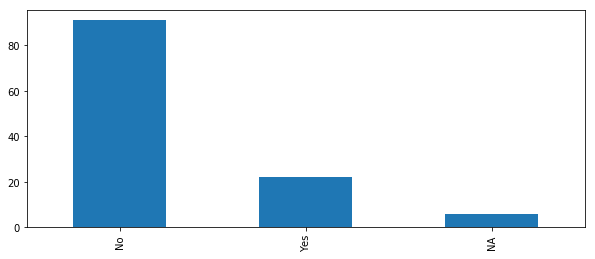

In [14]:
plt.figure(figsize=(10,4))
df.potentialMicrobial.value_counts().plot(kind='bar');

# Binarize the target, impute any missing value with the mode

In [15]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    #print(len(fsha_data))
    for i in range (len(fsha_data)):
        #print(i)
        ##print(fsha_data[targetName].values(i))
        if fsha_data[targetName].values[i]=='Yes':
            train_y.append(1)
        elif fsha_data[targetName].values[i]=='No':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

In [16]:

features_df["tags"] = impute_target(df,"potentialMicrobial")


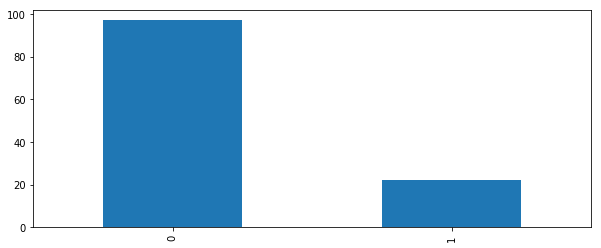

In [17]:
plt.figure(figsize=(10,4))
features_df.tags.value_counts().plot(kind='bar');

In [18]:
features_df.tags.value_counts()

0    97
1    22
Name: tags, dtype: int64

The classes are not balanced, but we see higher count of 1, based on new data

In [19]:
def print_plot(index):
    example = features_df[features_df.index == index][['concat_text', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])

# Have a look a few concatenated text and target pairs.

In [20]:
print_plot(10)

dtc ultimate cheddar  dtc ultimate cheddar seasoning (ing0001142/ 30049403) on tortilla chips tbd (component # - sff0000042) dtc ultimate cheddar doritos tortilla chips fried tortilla chips - whole corn is cooked, alkaline soaked, washed, milled, sheeted, cut, toasted, fried, salted or seasoned, and packaged. na none n/a since low moisture food  low moisture food: water activity <0.3 n/a since low moisture food none ambient; no special requirements none no shelf-life mode of failure is loss of flavor and texture staling; not food safety related.  no
Tag: 0


In [21]:
print_plot(5)

doritos flamin hot nacho  doritos flamin hot nacho seasoning will be topically applied seasoning onto doritos tortilla chips, added at 9.5% application rate.  fl3313-34 doritos flamin hot nacho  doritos tortilla chips fried  na none n/a since low moisture food  low moisture food: water activity <0.3 n/a since low moisture food none ambient; no special requirements none no shelf-life mode of failure is loss of flavor and texture staling; not food safety related.  no
Tag: 0


# Clean the text (remove punctuation, symbols, lowercase etc)

In [22]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [23]:
features_df['concat_text'] = features_df['concat_text'].apply(clean_text)

# Check a sample row of cleaned text

In [24]:
print_plot(0)

nacho cheese doritos export china korea nacho cheese doritos export china korea reformulated nacho cheese seasoning dtc nacho chi kor seas ing0000532 30049402 regulatory compliant china korea product produced modesto ca shipped transpacific china costco take delivery koreabound product ca ff3324 nacho cheese doritos export china korea doritos tortilla chips fried tortilla chips whole corn cooked alkaline soaked washed milled sheeted cut toasted fried salted seasoned packaged na none n since low moisture food low moisture food water activity 03 n since low moisture food none ambient special requirements none shelflife mode failure loss flavor texture staling food safety related
Tag: 0


In [25]:
features_df['concat_text'].apply(lambda x: len(x.split(' '))).sum()

9908

In [316]:
features_df.index.values.flatten()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
      dtype=int64)

# Train Test Split

In [26]:
X = features_df.concat_text
y = features_df.tags
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state = 42)

In [27]:
X = pd.DataFrame(features_df,columns=['concat_text','File Name'])
y = pd.DataFrame(features_df.tags)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state = 42)

In [28]:

X_test.head()

,concat_text,File Name
14,lays habanero national launch 2019 expand dist...,Lay's Fiery Habanero Combined FSHA Form-Fast T...
27,imagne cheese stars 2018 imagne cheese stars c...,Imagine Cheese Stars FSHA Final.xlsm
25,2019 lays flavor lto program launch four new l...,Lay's Turn Up the Flavor LTO- Dill Pickle-FSHA...
23,simply cheetos crunchy white cheddar jalapeno ...,Simply Cheetos Crunchy White Cheddar Jalapeno ...
26,2019 lays flavor lto program launch lays flami...,Lay's Turn Up the Flavor LTO_Lay's Flamin' Hot...


In [29]:
y_test = y_test['tags']
#y_test

# Upsample the target data, since the data is highly imbalanced

In [30]:
from sklearn.utils import resample

# concatenate our training data back together
X1 = pd.concat([X_train.concat_text, y_train], axis=1)

# separate minority and majority classes
not_potMicrobial = X1[X1.tags==0]
potMicrobial = X1[X1.tags==1]

In [31]:
len(not_potMicrobial)

77

In [32]:
len(potMicrobial)

18

In [33]:
# upsample minority
potMicrobial_upsampled = resample(potMicrobial,
                          replace=True, # sample with replacement
                          n_samples=len(not_potMicrobial), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([potMicrobial_upsampled, not_potMicrobial])

In [35]:
# check new class counts - now we have balanced data
upsampled.tags.value_counts()

1    77
0    77
Name: tags, dtype: int64

In [36]:
y_train = upsampled.tags
X_train = upsampled.drop('tags', axis=1)

In [37]:
#y_train=y_train.reshape(y_train.shape[0],1)
y_train=y_train.values.reshape(y_train.shape[0],1)

In [38]:
y_train.shape

(154, 1)

In [39]:
X_train.shape

(154, 1)

In [473]:
#X_train['concat_text'].values[5]

'nf n3 tropicana tropicana gunaydintur change fruit juice variety tropicana gunaydintur tropicana good morning juice drink walnut flavour honey nf n3 tropicana tropicana gunaydinturlaunch new juice drink 30 juice tropicana gunaydin good morning mixed fruit drink walnut flavouring honey 01 compliance silver criteria sugar content max 5 w v na na none titratable acidity 025 citric acid n tetrapak none ambient storage distribution none 9 months product needs stored refrigerator consumed within 2 days package opened'

In [40]:
X_train = X_train['concat_text'].values

In [41]:
X_train[5]

'nf n3 tropicana tropicana gunaydintur change fruit juice variety tropicana gunaydintur tropicana good morning juice drink walnut flavour honey nf n3 tropicana tropicana gunaydinturlaunch new juice drink 30 juice tropicana gunaydin good morning mixed fruit drink walnut flavouring honey 01 compliance silver criteria sugar content max 5 w v na na none titratable acidity 025 citric acid n tetrapak none ambient storage distribution none 9 months product needs stored refrigerator consumed within 2 days package opened'

In [42]:
X_test.values[0]
X_test.head()

,concat_text,File Name
14,lays habanero national launch 2019 expand dist...,Lay's Fiery Habanero Combined FSHA Form-Fast T...
27,imagne cheese stars 2018 imagne cheese stars c...,Imagine Cheese Stars FSHA Final.xlsm
25,2019 lays flavor lto program launch four new l...,Lay's Turn Up the Flavor LTO- Dill Pickle-FSHA...
23,simply cheetos crunchy white cheddar jalapeno ...,Simply Cheetos Crunchy White Cheddar Jalapeno ...
26,2019 lays flavor lto program launch lays flami...,Lay's Turn Up the Flavor LTO_Lay's Flamin' Hot...


In [432]:
#X_test = X_test.values

In [451]:
#X_test.head()

In [453]:
#X_train[0]

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers. 

### Naive Bayes classifier for multinomial models

In [43]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])
nb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [44]:
%%time
from sklearn.metrics import classification_report,f1_score
y_pred = nb.predict(X_test.concat_text)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 0.96
f1-score 0.96
             precision    recall  f1-score   support

          0       1.00      0.95      0.97        20
          1       0.80      1.00      0.89         4

avg / total       0.97      0.96      0.96        24

Wall time: 6.02 ms


In [46]:
print(np.where(y_test==1))

(array([ 5,  7, 13, 18], dtype=int64),)


In [48]:
print(np.where(y_pred==1))

(array([ 5,  7, 12, 13, 18], dtype=int64),)


In [49]:
y_pred1 = pd.DataFrame(y_pred,columns=['Predicted Microbial'])
y_pred1.head()

,Predicted Microbial
0,0
1,0
2,0
3,0
4,0


In [50]:
y_pred1.index = X_test.index
y_pred1

,Predicted Microbial
14,0
27,0
25,0
23,0
26,0
15,1
21,0
4,1
31,0
20,0


In [51]:
y_test1 = pd.DataFrame(y_test)
y_test1.head()

,tags
14,0
27,0
25,0
23,0
26,0


In [52]:
output_df = pd.concat([X_test,y_test1,y_pred1],axis=1)
output_df.head()

,concat_text,File Name,tags,Predicted Microbial
14,lays habanero national launch 2019 expand dist...,Lay's Fiery Habanero Combined FSHA Form-Fast T...,0,0
27,imagne cheese stars 2018 imagne cheese stars c...,Imagine Cheese Stars FSHA Final.xlsm,0,0
25,2019 lays flavor lto program launch four new l...,Lay's Turn Up the Flavor LTO- Dill Pickle-FSHA...,0,0
23,simply cheetos crunchy white cheddar jalapeno ...,Simply Cheetos Crunchy White Cheddar Jalapeno ...,0,0
26,2019 lays flavor lto program launch lays flami...,Lay's Turn Up the Flavor LTO_Lay's Flamin' Hot...,0,0


In [53]:
final_output = pd.merge(df,output_df, on='File Name', how='inner')
final_output.head()

,File Name,projName,accolNumber,PDA_projName,projType,projDesc,formulaNumber,owner,sector,center,...,Table1_Row6_Soya,Table1_Row6_Celery,Table1_Row6_Lupin,Table1_Row6_Molluscs,Table1_Row6_Mustard,Table1_Row6_Sesame Seeds,Table1_Row6_Sulphites,concat_text,tags,Predicted Microbial
0,Combined FSHA LKC jalapeno productivity 112920...,LKC jalapeno seasoning productivity,none,Lays Kettle Cooked jalapeno seasoning producti...,productivity,Cost reduced seasoning - a 11.68% price/lb sea...,FFM8724,Holly Ramage x4257,FLNA,plano,...,0,0,0,0,0,0,0,lkc jalapeno seasoning productivity cost reduc...,0,0
1,combined FSHA LKC lightly salted jalapeno in p...,LKC Lightly Salted Jalapeno,50498,Lays Kettle Cooked lightly salted jalapeno,Refresh,A refresh seasoning innovation to create a lig...,FFM0008298,Holly Ramage x4257,FLNA,plano,...,0,0,0,0,0,0,0,lkc lightly salted jalapeno refresh seasoning ...,0,0
2,Lay's Fiery Habanero Combined FSHA Form-Fast T...,Lay's Habanero National Launch 2019,44832,Lay's Fiery Habanero,Refresh,Expand the distribution of Lay's Fiery Habaner...,FFM8180 version 2,Ann Robarge,FLNA,Plano,...,0,0,0,0,0,0,0,lays habanero national launch 2019 expand dist...,0,0
3,Lay's Turn Up the Flavor LTO_Wavy Lay's Lemon ...,2019 Lay’s Flavor LTO Program,46005,Lay's Wavy Lemon Lime,Refresh,Launch Lay's Wavy Lemon Lime (ING0001511 / 300...,FFM0008315,"Ann Robarge, x4147",FLNA,Plano,...,0,0,0,0,0,0,0,2019 lays flavor lto program launch lays wavy ...,0,0
4,Red Rock Deli Aged Cheddar & Dijon Potato Chip...,Red Rock Deli - Aged Cheddar & Dijon 2019,34816,Red Rock Deli Aged Cheddar & Dijon Deli Style ...,Refresh,Create a new topical seasoning (Chadder aged &...,FFM0008276,Ann Robarge / x4147,FLNA,Plano,...,0,0,0,0,0,0,0,red rock deli aged cheddar dijon 2019 create n...,0,0


In [54]:

output_ = pd.read_excel("C:/Pepsico/ML_Output_potMicrobial.xlsm")
output_.columns

Index(['File Name', 'Project Name', 'Accolade Number', 'Product Name',
       'Project Type', 'Project Description', 'Formula Number ',
       'R&D Project Owner(s)', 'Sector', 'Originating R&D Cente',
       'Current TSG Stage', 'Food Safety Assessor(s)', 'Date Submitted to FS',
       'Which HTD Type Does This FSHA Version Pertain to',
       'Manufacturing site(s) for product', 'Plant trial location for product',
       'Note any novel packaging materials or uses',
       'Category Product Desc - Product Name',
       'Category Product Name and Brief Description', 'Process platform',
       'Intrinsic product attributes that may impact safety & stability ',
       'preservatives', 'pH or Titratable Acidity', 'waterActivity',
       'packaging', 'Other Food Safety Attributes', 'allergens',
       'Product Storage & Distribution Requirements', 'shelfLife',
       'Target Consumer Group', 'Food Safety-Related Product Claims',
       'Will the product be cooked or heated by the consumer

In [55]:
final_output.columns.values.flatten()

array(['File Name', 'projName', 'accolNumber', 'PDA_projName', 'projType',
       'projDesc', 'formulaNumber', 'owner', 'sector', 'center',
       'Current TSG Stage', 'FSAssessors', 'FSDate', 'WHTD',
       'manufacSite', 'PlantTrial', 'packMaterial', 'CPD-ProdName',
       'CPD-ProdName-Desc', 'procPlat', 'intrinsicProd', 'preservatives',
       'pH', 'waterActivity', 'packaging', 'otherFSA', 'allergens',
       'prodStorageDist', 'shelfLife', 'TCG', 'foodSafetyProdClaims',
       'cookedOrHeated', 'specificStorage', 'labelingInstructions',
       'mishandled', 'targetMarket', 'fastTrack', 'baseProduct',
       'prodModifications', 'newIngredient', 'approvedPackage',
       'potentialMicrobial', 'crossContactAllergens', 'chokeHazard',
       'operationalAllergen', 'allergensLabeledIMAF',
       'Table1_Row1_Cereals containing Gluten', 'Table1_Row1_Crustaceans',
       'Table1_Row1_Eggs', 'Table1_Row1_Fish', 'Table1_Row1_Milk',
       'Table1_Row1_Nuts', 'Table1_Row1_Peanuts', 'Table1

In [56]:
final_output_1 = final_output.drop([ 'crossContactAllergens', 'chokeHazard',
       'operationalAllergen', 'allergensLabeledIMAF',
       'Table1_Row1_Cereals containing Gluten', 'Table1_Row1_Crustaceans',
       'Table1_Row1_Eggs', 'Table1_Row1_Fish', 'Table1_Row1_Milk',
       'Table1_Row1_Nuts', 'Table1_Row1_Peanuts', 'Table1_Row1_Soya',
       'Table1_Row1_Celery', 'Table1_Row1_Lupin', 'Table1_Row1_Molluscs',
       'Table1_Row1_Mustard', 'Table1_Row1_Sesame Seeds',
       'Table1_Row1_Sulphites', 'Table1_Row2_Cereals containing Gluten',
       'Table1_Row2_Crustaceans', 'Table1_Row2_Eggs', 'Table1_Row2_Fish',
       'Table1_Row2_Milk', 'Table1_Row2_Nuts', 'Table1_Row2_Peanuts',
       'Table1_Row2_Soya', 'Table1_Row2_Celery', 'Table1_Row2_Lupin',
       'Table1_Row2_Molluscs', 'Table1_Row2_Mustard',
       'Table1_Row2_Sesame Seeds', 'Table1_Row2_Sulphites',
       'Table1_Row3_Cereals containing Gluten', 'Table1_Row3_Crustaceans',
       'Table1_Row3_Eggs', 'Table1_Row3_Fish', 'Table1_Row3_Milk',
       'Table1_Row3_Nuts', 'Table1_Row3_Peanuts', 'Table1_Row3_Soya',
       'Table1_Row3_Celery', 'Table1_Row3_Lupin', 'Table1_Row3_Molluscs',
       'Table1_Row3_Mustard', 'Table1_Row3_Sesame Seeds',
       'Table1_Row3_Sulphites', 'Table1_Row4_Cereals containing Gluten',
       'Table1_Row4_Crustaceans', 'Table1_Row4_Eggs', 'Table1_Row4_Fish',
       'Table1_Row4_Milk', 'Table1_Row4_Nuts', 'Table1_Row4_Peanuts',
       'Table1_Row4_Soya', 'Table1_Row4_Celery', 'Table1_Row4_Lupin',
       'Table1_Row4_Molluscs', 'Table1_Row4_Mustard',
       'Table1_Row4_Sesame Seeds', 'Table1_Row4_Sulphites',
       'Table1_Row5_Cereals containing Gluten', 'Table1_Row5_Crustaceans',
       'Table1_Row5_Eggs', 'Table1_Row5_Fish', 'Table1_Row5_Milk',
       'Table1_Row5_Nuts', 'Table1_Row5_Peanuts', 'Table1_Row5_Soya',
       'Table1_Row5_Celery', 'Table1_Row5_Lupin', 'Table1_Row5_Molluscs',
       'Table1_Row5_Mustard', 'Table1_Row5_Sesame Seeds',
       'Table1_Row5_Sulphites', 'Table1_Row6_Cereals containing Gluten',
       'Table1_Row6_Crustaceans', 'Table1_Row6_Eggs', 'Table1_Row6_Fish',
       'Table1_Row6_Milk', 'Table1_Row6_Nuts', 'Table1_Row6_Peanuts',
       'Table1_Row6_Soya', 'Table1_Row6_Celery', 'Table1_Row6_Lupin',
       'Table1_Row6_Molluscs', 'Table1_Row6_Mustard',
       'Table1_Row6_Sesame Seeds', 'Table1_Row6_Sulphites', 'concat_text',
       'tags'],axis = 1)

In [57]:
final_output_1.columns = output_.columns
final_output_1.columns

Index(['File Name', 'Project Name', 'Accolade Number', 'Product Name',
       'Project Type', 'Project Description', 'Formula Number ',
       'R&D Project Owner(s)', 'Sector', 'Originating R&D Cente',
       'Current TSG Stage', 'Food Safety Assessor(s)', 'Date Submitted to FS',
       'Which HTD Type Does This FSHA Version Pertain to',
       'Manufacturing site(s) for product', 'Plant trial location for product',
       'Note any novel packaging materials or uses',
       'Category Product Desc - Product Name',
       'Category Product Name and Brief Description', 'Process platform',
       'Intrinsic product attributes that may impact safety & stability ',
       'preservatives', 'pH or Titratable Acidity', 'waterActivity',
       'packaging', 'Other Food Safety Attributes', 'allergens',
       'Product Storage & Distribution Requirements', 'shelfLife',
       'Target Consumer Group', 'Food Safety-Related Product Claims',
       'Will the product be cooked or heated by the consumer

In [58]:
final_output_1.head(1)

,File Name,Project Name,Accolade Number,Product Name,Project Type,Project Description,Formula Number,R&D Project Owner(s),Sector,Originating R&D Cente,...,Labeling Instructions,Is the product likely to be mishandled by the consumer,Are there any vulnerable groups in the target market?,Is This Project Eligible for Fast Track TSG,Is there a new base product?,Are there new equipment or process modifications?,Is there a new ingredient supplier or supplier site?,"Are there novel packaging materials or, for already approved packaging materials, will they be used in a novel way",Is there a potential for microbial growth in the product?- actual,Is there a potential for microbial growth in the product?- predicted
0,Combined FSHA LKC jalapeno productivity 112920...,LKC jalapeno seasoning productivity,none,Lays Kettle Cooked jalapeno seasoning producti...,productivity,Cost reduced seasoning - a 11.68% price/lb sea...,FFM8724,Holly Ramage x4257,FLNA,plano,...,None,No,no,Fast Track is allowed for this project.,No,No,No,No,No,0


In [59]:
 final_output_1['Is there a potential for microbial growth in the product?- actual'].value_counts()

No     20
Yes     4
Name: Is there a potential for microbial growth in the product?- actual, dtype: int64

In [60]:
final_output_1['Is there a potential for microbial growth in the product?- predicted'] = final_output_1['Is there a potential for microbial growth in the product?- predicted'].apply(lambda x: 'Yes' if x == 1 else 'No' )

In [61]:
final_output_1.to_csv('C:/Pepsico/Final output format.csv',index = False)

In [524]:
#final_output.to_csv('Final output format.csv')

In [185]:
X = np.concatenate((X_train,X_test))

In [186]:
len(X)

178

In [187]:
X=X.reshape(X.shape[0],)

In [188]:
#y_test=y_test.reshape(y_test.shape[0],1)
y_test=y_test.values.reshape(y_test.shape[0],1)

In [189]:
y = np.concatenate((y_train,y_test))

In [190]:
y=y.reshape(y.shape[0],)

In [191]:
X.shape

(178,)

In [192]:
X_train.shape

(154,)

1650
after fit


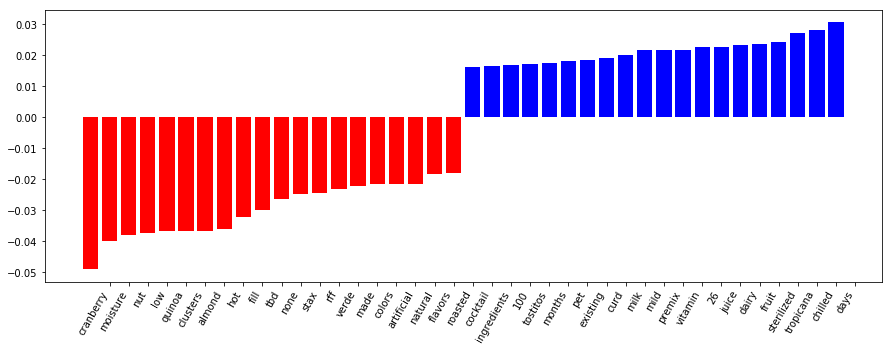

In [193]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.show()

cv = CountVectorizer()
cv.fit(X)
print(len(cv.vocabulary_))
#print(cv.get_feature_names())
X_train = cv.transform(X_train)

svm = LinearSVC()
svm.fit(X_train, y_train)
print("after fit")
plot_coefficients(svm, cv.get_feature_names())

In [254]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn),'fp': make_scorer(fp), 'fn': make_scorer(fn)}
#cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cv_results = cross_validate(nb.fit(X, y), X, y,scoring=scoring, cv=5)

In [256]:
#kfold
from sklearn import model_selection
kfold = model_selection.KFold(n_splits=10, random_state=0)
results = model_selection.cross_val_score(nb.fit(X, y), X, y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

Accuracy: 98.301% (2.597%)


In [250]:
#leaveoneout: special case of kfold where size of fold is 1
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
loocv = model_selection.LeaveOneOut()
scores = cross_val_score(nb.fit(X, y) , X  , y  , cv = loocv) 
print("Accuracy: %.3f%% (%.3f%%)" % (scores.mean()*100.0, scores.std()*100.0))

Accuracy: 98.876% (10.540%)


In [249]:
print(cv_results['test_tp'])  
print(cv_results['test_tn']) 
# Getting the test set false negative scores
print(cv_results['test_fn'])  
print(cv_results['test_fp']) 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [196]:
print(cv_results)

{'fit_time': array([0.02601862, 0.02401853, 0.02401614, 0.03001881, 0.02351856]), 'score_time': array([0.0250206 , 0.02301478, 0.0240159 , 0.03003454, 0.0240159 ]), 'test_tp': array([17, 16, 16, 16, 16]), 'train_tp': array([64, 65, 65, 65, 65]), 'test_tn': array([20, 19, 19, 19, 18]), 'train_tn': array([77, 77, 78, 78, 78]), 'test_fp': array([0, 1, 0, 0, 1]), 'train_fp': array([0, 0, 0, 0, 0]), 'test_fn': array([0, 0, 0, 0, 0]), 'train_fn': array([0, 0, 0, 0, 0])}


In [197]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from pprint import pprint
from time import time
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(tol=1e-3)),
])


In [198]:


parameters = {
    'vect__max_df': ( 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}
# multiprocessing requires the fork to happen in a __main__ protected
# block

# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, cv=5,n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X, y)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (20,),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   37.4s finished


done in 38.104s

Best score: 0.994
Best parameters set:
	clf__alpha: 1e-05
	clf__max_iter: 20
	clf__penalty: 'l2'
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)


In [68]:
y_pred

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0], dtype=int64)

In [69]:
y_test

0     0
1     0
2     0
3     0
4     0
5     1
6     0
7     1
8     0
9     0
10    0
11    0
12    0
13    1
14    0
15    0
16    0
17    0
18    1
19    0
20    0
21    0
22    0
23    0
Name: tags, dtype: int64

### SGDClassifier

In [161]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

AttributeError: lower not found

In [162]:
X_train.shape

(154, 1650)

In [73]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

NotFittedError: CountVectorizer - Vocabulary wasn't fitted.

### Logistic regression

In [74]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

AttributeError: lower not found

In [56]:
%%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test).round(2))
print('f1-score %s' % f1_score(y_pred, y_test,average='weighted').round(2))
print(classification_report(y_test, y_pred))

accuracy 1.0
f1-score 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        20
          1       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00        24

Wall time: 0 ns


Confusion matrix, without normalization
[[20  0]
 [ 0  4]]


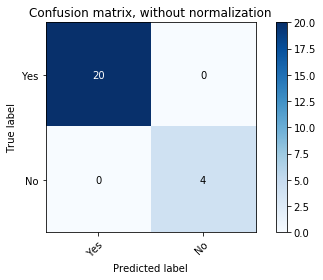

In [58]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_names=['Yes','No']
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                      title='Normalized confusion matrix')

plt.show()

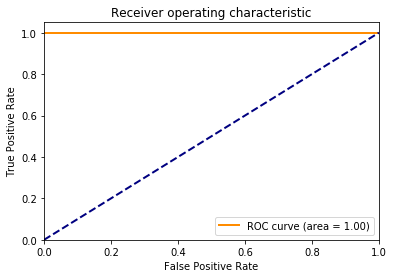

In [59]:
from sklearn.metrics import roc_curve, auc
true_labels = y_test
scores = y_pred
### actual code for roc + threshold charts start here 
# compute fpr, tpr, thresholds and roc_auc
fpr, tpr, thresholds = roc_curve(true_labels, scores)
roc_auc = auc(fpr, tpr) # compute area under the curve
 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# We find the both Target Yes and No is predicted with 99% accuracy , but if we add the fourth Data extract from Additional FSHAs 1 folder, the accuracy of the Yes becomes zero, and accuracy of No is 99%, showing this set of files have errorneous data.